## Problem statement: 
### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The data set contains the following diseases:

Actinic keratosis
Basal cell carcinoma
Dermatofibroma
Melanoma
Nevus
Pigmented benign keratosis
Seborrheic keratosis
Squamous cell carcinoma
Vascular lesion

### Importing Skin Cancer Data
#### Read the data

### Importing all the important libraries

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## Data Reading/Data Understanding 

In [5]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("C:/Users/SAKSHISINGH/Downloads/CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('C:/Users/SAKSHISINGH/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
from tensorflow.keras.preprocessing.image import load_img

Found 6739 files belonging to 9 classes.


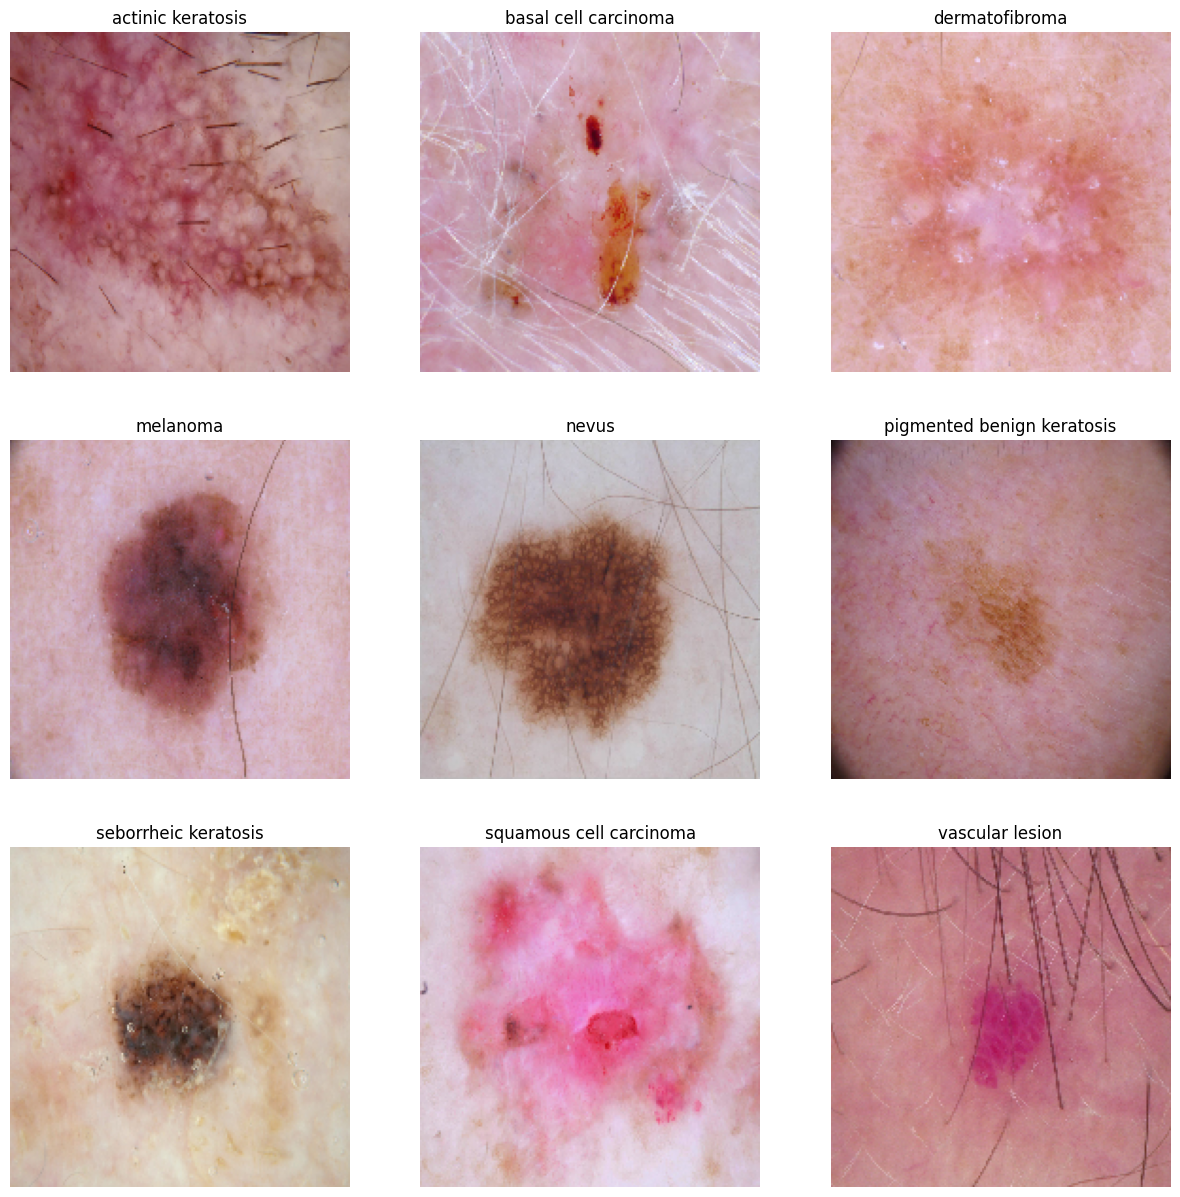

In [9]:

## Used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resize the images 
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [10]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [11]:
## Validation dataset 
## Used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resize the images to the size img_height*img_width
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [12]:
# List out all the classes of skin cancer and stored them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

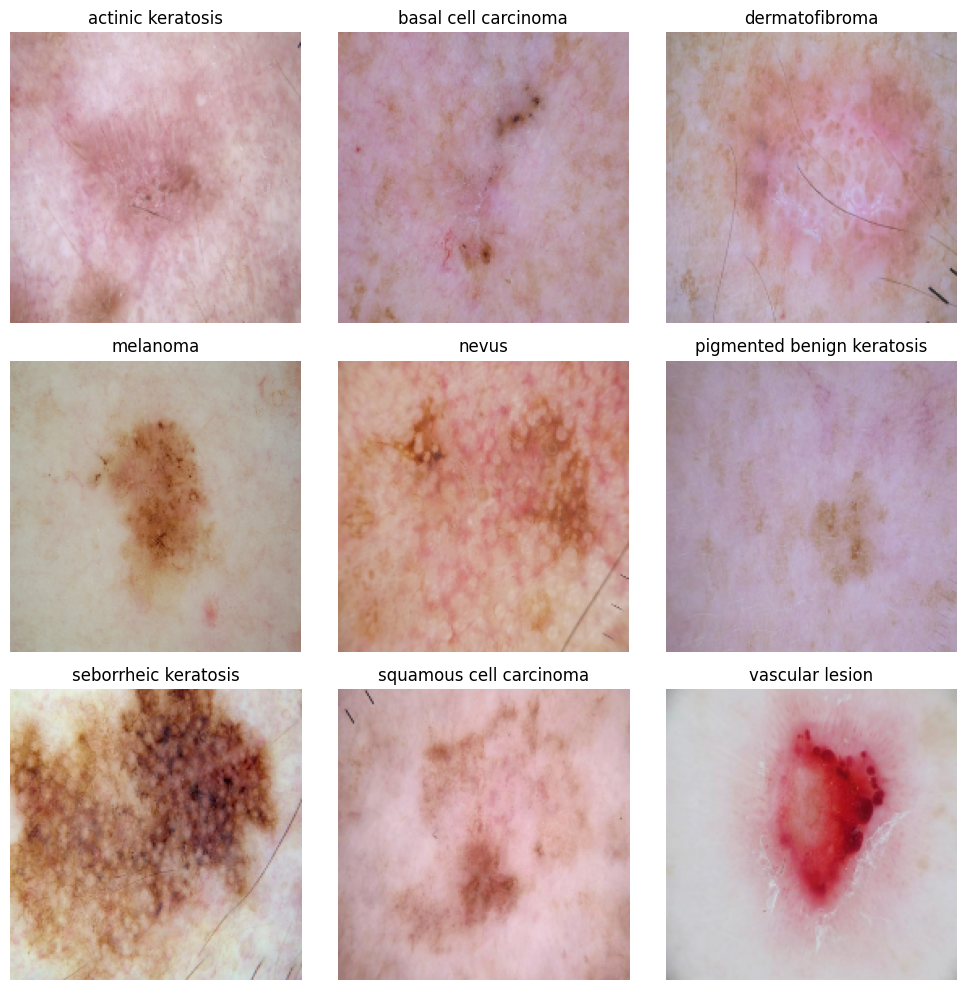

In [13]:
import matplotlib.pyplot as plt

class_images = {i: None for i in range(len(class_names))}

# Iterate through the dataset to find one image per class
for images, labels in train_ds:
    # `labels` is a batch of one-hot encoded labels, so we need to convert them to class indices
    for image, label in zip(images.numpy(), labels.numpy()):
        label_index = np.argmax(label)  # Convert the one-hot encoded label to class index
        
        # Store the first image found for each class
        if class_images[label_index] is None:
            class_images[label_index] = image  # Store the first image found for this class
    
    # Stop once we have one image for each class
    if all(value is not None for value in class_images.values()):
        break

# Plot one image from each class
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Adjust to show 3x3 grid of images
axes = axes.ravel()

for i, (class_id, image) in enumerate(class_images.items()):
    if image is not None:
        axes[i].imshow(image.astype("uint8"))  # Directly use the image, without calling .numpy()
        axes[i].set_title(class_names[class_id])
        axes[i].axis('off')

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

Class  No. of Image
0           actinic keratosis           114
1        basal cell carcinoma           376
2              dermatofibroma            95
3                    melanoma           438
4                       nevus           357
5  pigmented benign keratosis           462
6        seborrheic keratosis            77
7     squamous cell carcinoma           181
8             vascular lesion           139

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Building & training


In [16]:
num_class = 9
model = tf.keras.Sequential([
    layers.Input(shape=(180, 180, 3)),  # Use Input layer to specify input shape
    layers.Rescaling(scale=1./255),  
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),    
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

### Compile the model


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 70s 288ms/step - accuracy: 0.1774 - loss: 2.1749 - val_accuracy: 0.3519 - val_loss: 1.6576
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 262ms/step - accuracy: 0.4018 - loss: 1.5861 - val_accuracy: 0.3860 - val_loss: 1.5332
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 249ms/step - accuracy: 0.4457 - loss: 1.4670 - val_accuracy: 0.4425 - val_loss: 1.5431
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 248ms/step - accuracy: 0.5109 - loss: 1.2963 - val_accuracy: 0.4848 - val_loss: 1.3560
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 247ms/step - accuracy: 0.5293 - loss: 1.2477 - val_accuracy: 0.4818 - val_loss: 1.3449
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 253ms/step - accuracy: 0.5750 - loss: 1.1357 - val_accuracy: 0.4840 - val_loss: 1.3775
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 251ms/step - accuracy: 0.6142 - loss: 1.0357 - val_accuracy: 0.5100 - val_loss: 1.3499
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - accuracy: 0.6589 - loss: 0

### Visualizing training results

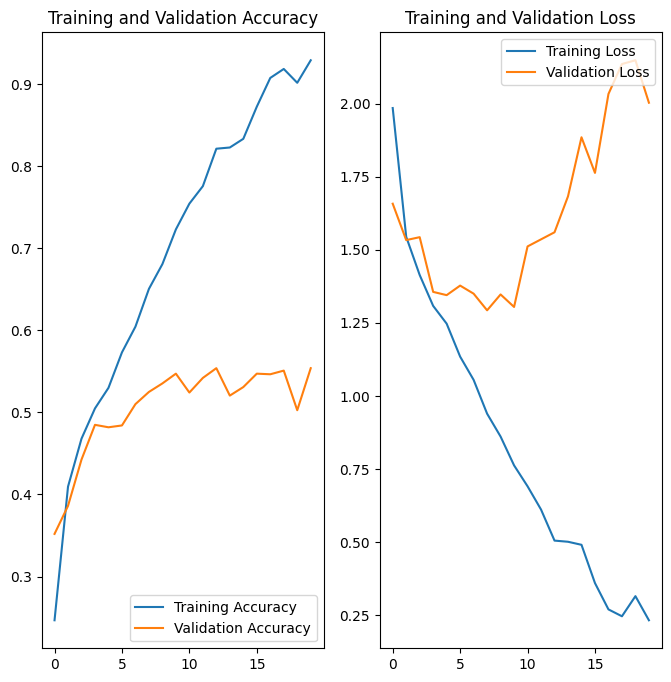

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Performance

In [57]:
loss, accuracy = model.evaluate(train_ds, verbose=1)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

281/281 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.6431 - loss: 0.9144
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.6403 - loss: 0.9825
Accuracy:  0.6519128084182739
Validation Accuracy:  0.6381842494010925
Loss:  0.9007996916770935
Validation Loss 0.9934401512145996


## Findings 
#### An accuracy of around 63-65% on both training and validation sets suggests that the model has learned useful patterns, but there is still room for improvement.
#### The small difference between the training and validation accuracy and loss (less than 1.5%) suggests that the model is not significantly overfitting or underfitting.


## Data Augmentation

In [21]:
# Data augumentation strategy 
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3))
])

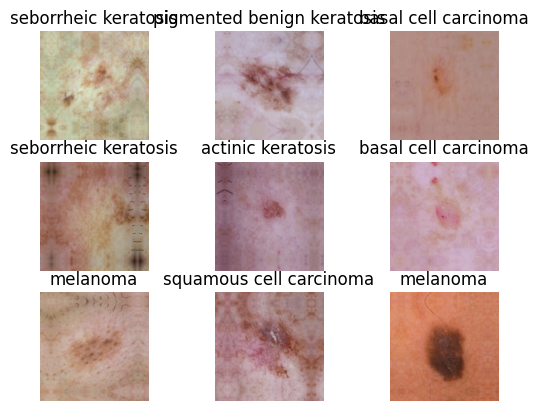

In [22]:
# Visualize of augmentation strategy works for one instance of training image.
for img, labels in train_ds.take(1):
    for i in range(9):  # Display 9 images with augmented versions
        ax = plt.subplot(3, 3, i + 1)
        
        # Apply data augmentation to the image and display it
        augmented_image = data_augmentation(img)[i].numpy().astype('uint8')
        plt.imshow(augmented_image)
        
        # Convert the label to a scalar integer by extracting the index from the one-hot encoding
        label_index = np.argmax(labels[i].numpy())  # Find the index of the '1' in one-hot encoding
        plt.title(class_names[label_index])  # Access class_names by index
        plt.axis("off")

plt.show()


### Create the model, compile and train the model


In [23]:
# Define the model with data augmentation and dropout layers
num_classes = 9
model = tf.keras.Sequential([
    # Data augmentation layer to apply transformations to the input images
        layers.InputLayer(shape=(180, 180, 3)),  # Explicitly specify the input shape

    layers.RandomFlip("horizontal_and_vertical"),  
    layers.RandomRotation(0.2),  # Corrected, no experimental prefix
    layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),  

    # Rescaling the images to [0, 1] range
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # Convolutional layers for feature extraction
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),

    # Dropout layer to prevent overfitting
    layers.Dropout(0.3),

    # Flatten the output and add dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Another Dropout after the dense layer

    # Output layer with the number of classes
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])






C:\Users\SAKSHISINGH\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compiling the model

In [24]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # from_logits=False since we use softmax
              metrics=['accuracy'])

# Summarize the model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [25]:
## Train model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.1406 - loss: 2.2785 - val_accuracy: 0.2888 - val_loss: 1.8472
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 207ms/step - accuracy: 0.2864 - loss: 1.8933 - val_accuracy: 0.4120 - val_loss: 1.5597
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 207ms/step - accuracy: 0.3854 - loss: 1.6027 - val_accuracy: 0.4336 - val_loss: 1.4493
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 212ms/step - accuracy: 0.4311 - loss: 1.4938 - val_accuracy: 0.4046 - val_loss: 1.4782
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step - accuracy: 0.4224 - loss: 1.4745 - val_accuracy: 0.4499 - val_loss: 1.4337
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 208ms/step - accuracy: 0.4389 - loss: 1.4378 - val_accuracy: 0.4722 - val_loss: 1.3361
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 213ms/step - accuracy: 0.4531 - loss: 1.3991 - val_accuracy: 0.4803 - val_loss: 1.2942
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 208ms/step - accuracy: 0.4868 - loss: 1

### Visualizing the results

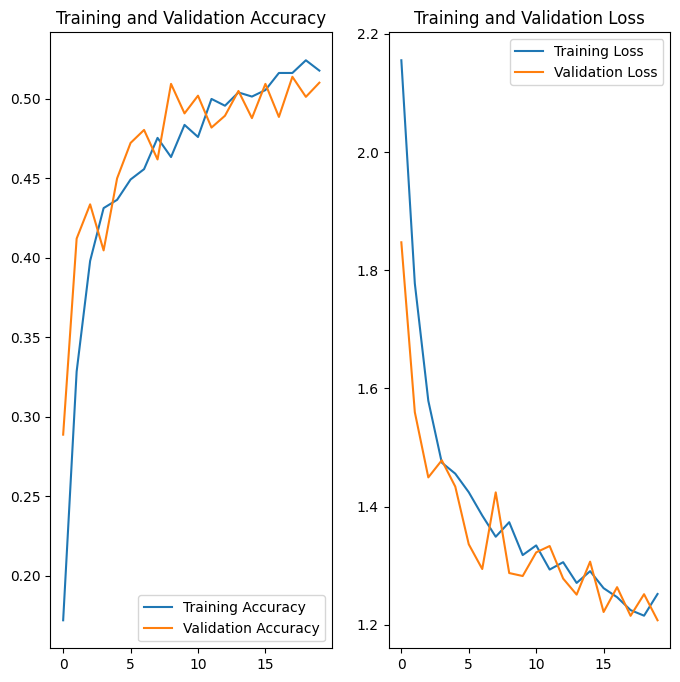

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Performance

In [59]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

281/281 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.6451 - loss: 0.9091
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.6420 - loss: 0.9691
Accuracy:  0.6519128084182739
Validation Accuracy:  0.6381842494010925
Loss:  0.9007998704910278
Validation Loss 0.9934400320053101


## Findings 
#### The small difference between the training and validation accuracy (~1.4%) suggests that the model is generalizing well to unseen data. 
#### The validation loss being slightly higher than the training loss is expected, but it would be beneficial to monitor this value as training progresses.

## Class imbalance

                  Class  No. of Images
0     actinic keratosis            493
1  basal cell carcinoma            721
2        dermatofibroma            455
3              melanoma            755
4                 nevus            677


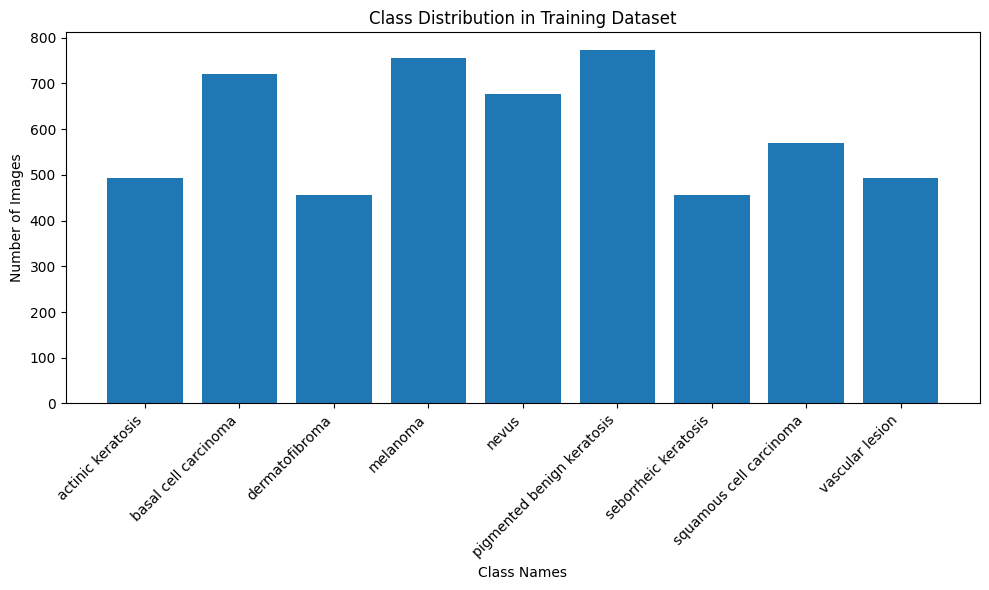

In [28]:
# Plot the class distribution as a bar char

# Create a dictionary to count the number of images per class
class_counts = {class_name: 0 for class_name in class_names}

# Iterate through the dataset to count the number of images per class
for images, labels in train_ds:
    labels = labels.numpy()  # Convert labels to numpy array
    for label in labels:
        class_index = label.argmax()  # Get the class index from the one-hot encoding
        class_counts[class_names[class_index]] += 1

# Convert the class counts to a DataFrame
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'No. of Images'])

# Verify the DataFrame structure
print(df.head())  # Ensure that 'Class' and 'No. of Images' columns exist

# Plot the class distribution as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(df['Class'], df['No. of Images'])
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate the class names to avoid overlap
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

In [45]:
path_list=[]
lesion_list=[]
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
print(original_df)

                                                   Path              Label
0     C:\Users\SAKSHISINGH\Downloads\CNN_assignment\...  actinic keratosis
1     C:\Users\SAKSHISINGH\Downloads\CNN_assignment\...  actinic keratosis
2     C:\Users\SAKSHISINGH\Downloads\CNN_assignment\...  actinic keratosis
3     C:\Users\SAKSHISINGH\Downloads\CNN_assignment\...  actinic keratosis
4     C:\Users\SAKSHISINGH\Downloads\CNN_assignment\...  actinic keratosis
...                                                 ...                ...
2234  C:\Users\SAKSHISINGH\Downloads\CNN_assignment\...    vascular lesion
2235  C:\Users\SAKSHISINGH\Downloads\CNN_assignment\...    vascular lesion
2236  C:\Users\SAKSHISINGH\Downloads\CNN_assignment\...    vascular lesion
2237  C:\Users\SAKSHISINGH\Downloads\CNN_assignment\...    vascular lesion
2238  C:\Users\SAKSHISINGH\Downloads\CNN_assignment\...    vascular lesion

[2239 rows x 2 columns]


<BarContainer object of 9 artists>

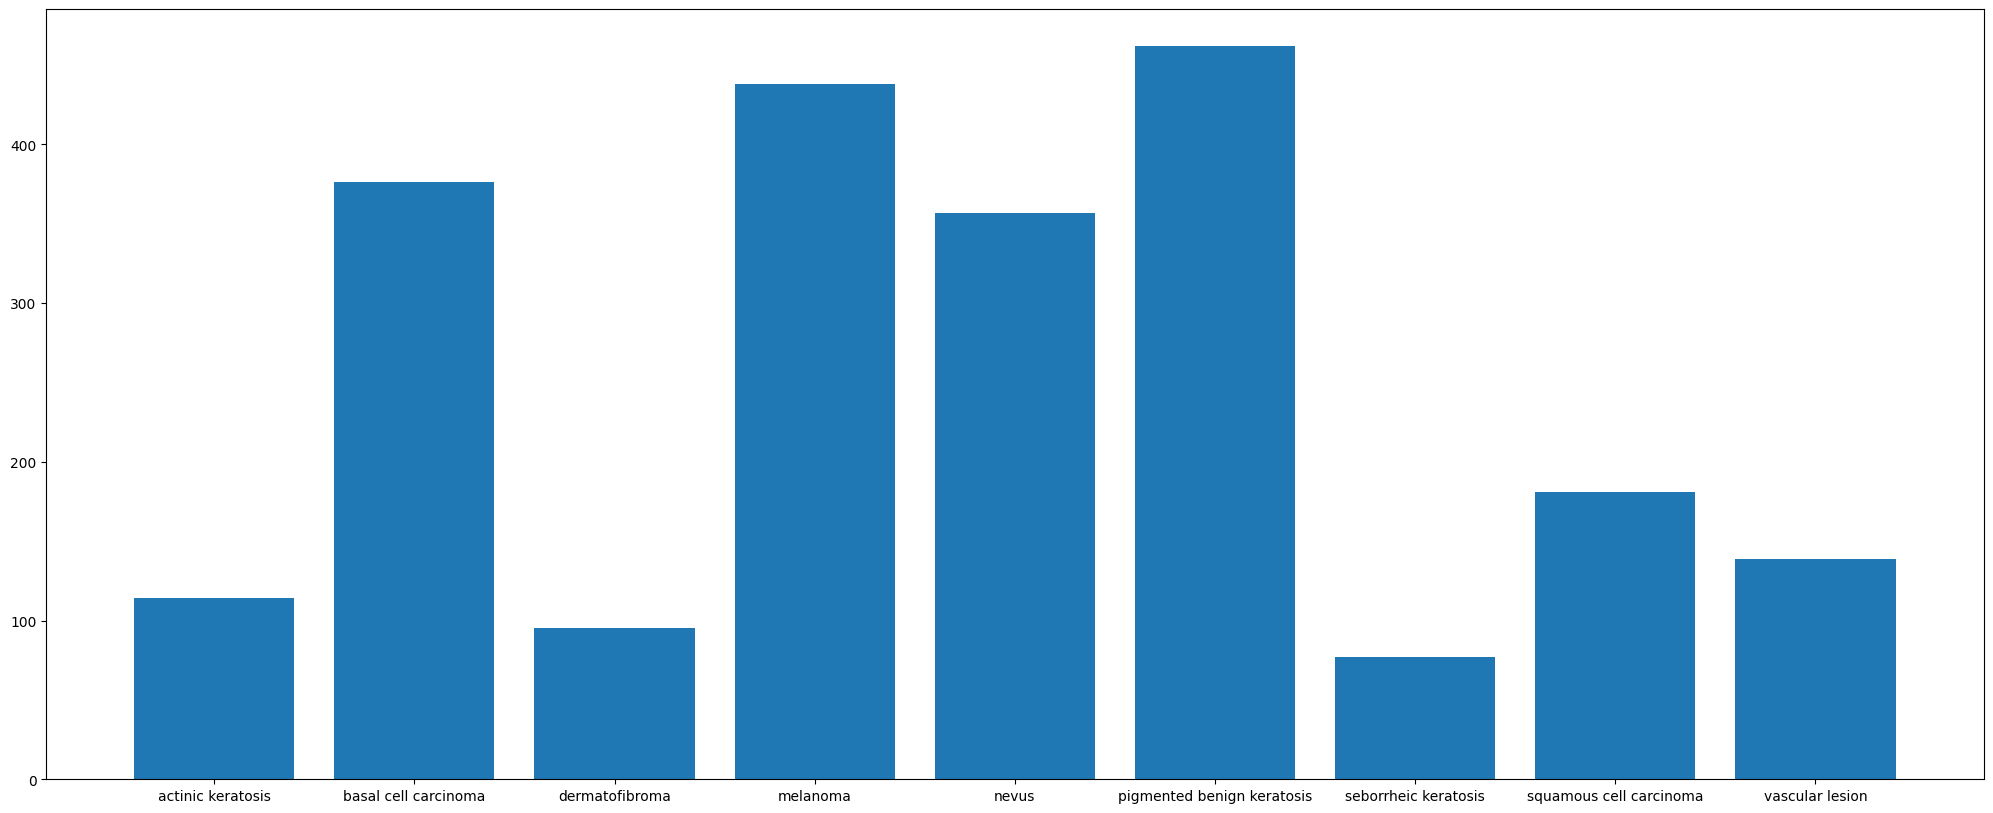

In [29]:
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

## Findings 
### - Which class has the least number of samples?
* The least number of samples are in seborrheic keratosis.
### Which classes dominate the data in terms proportionate number of samples?
#### The classes dominate in the data are:-
* pigmented benign keratosis
* melanoma
* basal cell carcinoma


## Rectifying the Class Imbalance using Augmentor library

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
import Augmentor
path_to_training_dataset="C:/Users/SAKSHISINGH/Downloads/CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration/Train"
class_names = os.listdir(path_to_training_dataset)

# Loop through each class to apply data augmentation
for class_name in class_names:
    class_path = os.path.join(path_to_training_dataset, class_name)
    
    # Check if the class directory exists
    if os.path.isdir(class_path):
        print(f"Augmenting images for class: {class_name}")
        
        # Initialize Augmentor pipeline for the current class
        p = Augmentor.Pipeline(class_path)
        
        # Apply data augmentations
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.flip_left_right(probability=0.5)
        p.flip_top_bottom(probability=0.5)
        p.zoom_random(probability=0.5, percentage_area=0.8)
        p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
        
        # Sample 500 additional images for each class
        p.sample(500)  
    else:
        print(f"Directory for class {class_name} not found. Skipping.")

print("Data augmentation applied to all valid classes.")

Augmenting images for class: actinic keratosis
Initialised with 114 image(s) found.
Output directory set to C:/Users/SAKSHISINGH/Downloads/CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration/Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A14879C510>: 100%|█| 500/500 [00:05<00:00, 84.27 Samples/


Augmenting images for class: basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to C:/Users/SAKSHISINGH/Downloads/CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration/Train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1A14898D690>: 100%|█| 500/500 [00:09<00:


Augmenting images for class: dermatofibroma
Initialised with 95 image(s) found.
Output directory set to C:/Users/SAKSHISINGH/Downloads/CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration/Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A033386550>: 100%|█| 500/500 [00:09<00:00, 51.23 Samples/


Augmenting images for class: melanoma
Initialised with 438 image(s) found.
Output directory set to C:/Users/SAKSHISINGH/Downloads/CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration/Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1A035BAAB90>: 100%|█| 500/500 [00:36<00:00, 13.85 Samples


Augmenting images for class: nevus
Initialised with 357 image(s) found.
Output directory set to C:/Users/SAKSHISINGH/Downloads/CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration/Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1A024FBA990>: 100%|█| 500/500 [00:27<00:00, 18.39 Samples


Augmenting images for class: pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to C:/Users/SAKSHISINGH/Downloads/CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration/Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A14881BB50>: 100%|█| 500/500 [00:04<00:00, 113.99 Samples


Augmenting images for class: seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to C:/Users/SAKSHISINGH/Downloads/CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration/Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1A148771190>: 100%|█| 500/500 [00:12<00:00, 39.20 Samples


Augmenting images for class: squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to C:/Users/SAKSHISINGH/Downloads/CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration/Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A148770FD0>: 100%|█| 500/500 [00:04<00:00, 112.52 Samples


Augmenting images for class: vascular lesion
Initialised with 139 image(s) found.
Output directory set to C:/Users/SAKSHISINGH/Downloads/CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration/Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A148797C50>: 100%|█| 500/500 [00:04<00:00, 103.26 Samples

Data augmentation applied to all valid classes.


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [49]:
from pathlib import Path
data_dir_train = Path("C:/Users/SAKSHISINGH/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Distribution of augmented data after adding new images to the original training data.

In [40]:
import glob
import os
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
print(path_list)

['C:\\Users\\SAKSHISINGH\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_32510554-cb84-4381-81e4-ec8d9581e760.jpg', 'C:\\Users\\SAKSHISINGH\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3924da46-d18a-4b46-9a2e-90b138319bdd.jpg', 'C:\\Users\\SAKSHISINGH\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_88b27bf5-d97e-4e34-8d45-c5880849cd67.jpg', 'C:\\Users\\SAKSHISINGH\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_add819ed-116e-4279-b113-f924de21d264.jpg', 'C:\\Users\\SAKSHISINGH\\Downloads\\CNN_assignment\\Ski

In [41]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [42]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])

# Use pd.concat() to append the two DataFrames
new_df = pd.concat([original_df, df2], ignore_index=True)

In [47]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [50]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [51]:
data_dir_train="C:/Users/SAKSHISINGH/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training' ,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### Create a validation dataset

In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### Model building include normalization

In [53]:
num_classes = 9

# Data augmentation can be added to the pipeline for better generalization
# Model creation
model = Sequential([
    data_augmentation,  # Data augmentation layer
    layers.Rescaling(1./255),  # Normalize image pixel values to [0, 1]
    
    # First convolutional block
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Second convolutional block
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Third convolutional block
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Dropout to prevent overfitting
    layers.Dropout(0.3),
    
    # Flatten the output for the fully connected layer
    layers.Flatten(),
    
    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    
    # Output layer with softmax activation for classification
    layers.Dense(num_classes, activation='softmax')
])




#### Compile model 

In [54]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Model summary to visualize the architecture
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 180, 180, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 90, 90, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 90, 90, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 45, 45, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 45, 45, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 22, 22, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (32, 22, 22, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (32, 30976)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (32, 128)                   │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 9)                     │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

#### Train model

#### Visualize the model results

In [55]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 281ms/step - accuracy: 0.1986 - loss: 2.0955 - val_accuracy: 0.3792 - val_loss: 1.6139
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 77s 274ms/step - accuracy: 0.3973 - loss: 1.5545 - val_accuracy: 0.4263 - val_loss: 1.4265
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 68s 243ms/step - accuracy: 0.4140 - loss: 1.4887 - val_accuracy: 0.4437 - val_loss: 1.4496
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 69s 244ms/step - accuracy: 0.4329 - loss: 1.4448 - val_accuracy: 0.4548 - val_loss: 1.3600
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 75s 267ms/step - accuracy: 0.4489 - loss: 1.4034 - val_accuracy: 0.4811 - val_loss: 1.2911
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 80s 285ms/step - accuracy: 0.4722 - loss: 1.3749 - val_accuracy: 0.4971 - val_loss: 1.2522
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 77s 273ms/step - accuracy: 0.4839 - loss: 1.3224 - val_accuracy: 0.5020 - val_loss: 1.2549
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 73s 261ms/step - accuracy: 0.4904 - loss: 1

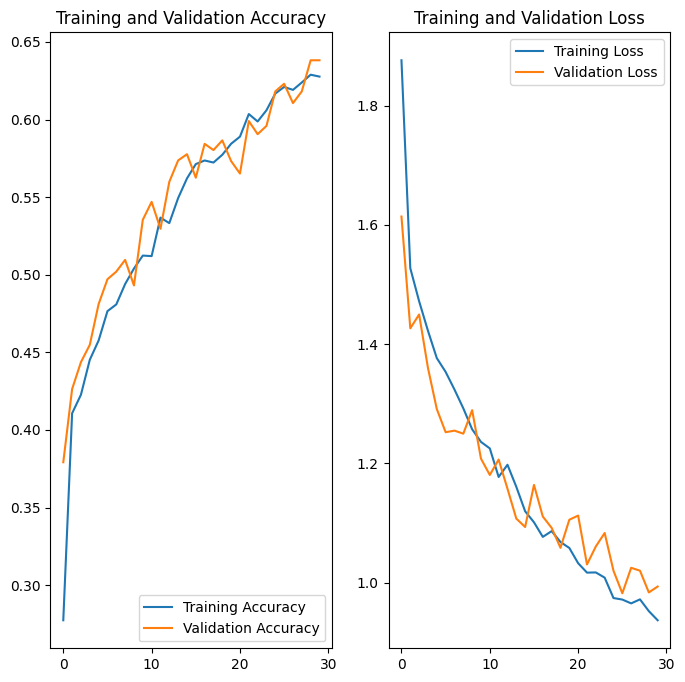

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)



281/281 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - accuracy: 0.6446 - loss: 0.9129
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.6384 - loss: 0.9795
Accuracy:  0.6519128084182739
Validation Accuracy:  0.6381842494010925
Loss:  0.9007998704910278
Validation Loss 0.9934400320053101


## Model prediction on test data set

Selected Random Image: C:\Users\SAKSHISINGH\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test\pigmented benign keratosis\ISIC_0024426.jpg
Selected Random Image: C:\Users\SAKSHISINGH\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test\melanoma\ISIC_0000029.jpg
Selected Random Image: C:\Users\SAKSHISINGH\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test\nevus\ISIC_0000006.jpg
Selected Random Image: C:\Users\SAKSHISINGH\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test\nevus\ISIC_0000009.jpg
Selected Random Image: C:\Users\SAKSHISINGH\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test\pigmented benign keratosis\ISIC_0024409.jpg
Selected Random Image: C:\Users\SAKSHISINGH\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test\nevus\ISIC_0000001.jpg
S

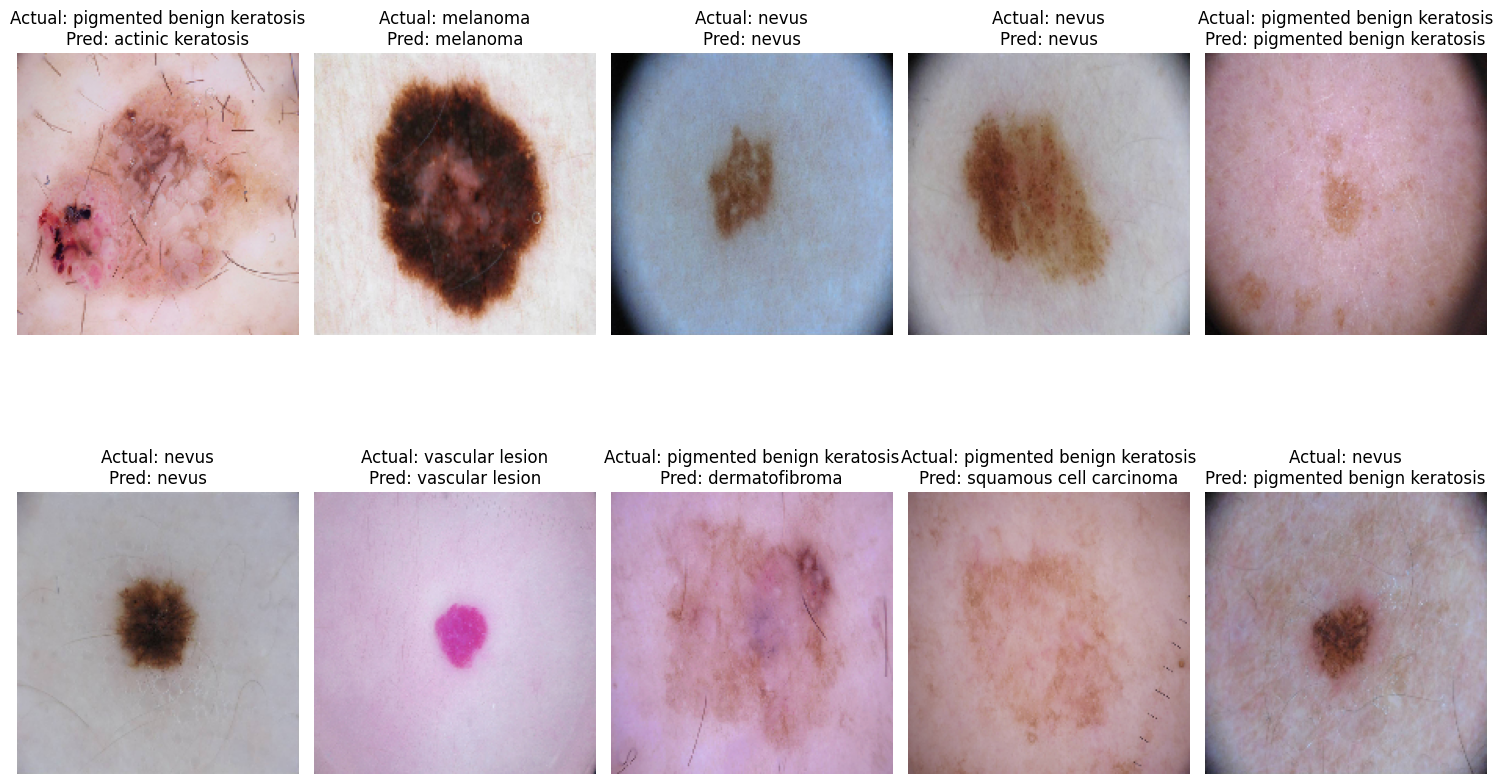

In [63]:
import random

# Path to test images
Test_image_path = os.path.join(data_dir_test, '*', '*')
Test_images = glob.glob(Test_image_path)

# Set up a plot grid for 10 images
plt.figure(figsize=(15, 10))  # Adjust figure size
num_images = 10

for i in range(num_images):
    # Randomly choose an image
    random_image_path = random.choice(Test_images)
    print(f"Selected Random Image: {random_image_path}")

    # Load the selected test image
    Test_image = keras.preprocessing.image.load_img(random_image_path, target_size=(180, 180, 3))

    # Preprocess the image
    Test_image_array = keras.preprocessing.image.img_to_array(Test_image)
    img = np.expand_dims(Test_image_array, axis=0)

    # Make prediction
    pred = model.predict(img, verbose=0)
    pred_index = np.argmax(pred)
    pred_class = class_names[pred_index]

    # Get actual class from file path
    actual_class = os.path.basename(os.path.dirname(random_image_path))

    # Display the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(Test_image)
    plt.title(f"Actual: {actual_class}\nPred: {pred_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [66]:
test_ds = keras.preprocessing.image_dataset_from_directory(
                  data_dir_test,
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)

loss_t, accuracy_t = model.evaluate(test_ds, verbose=1)
print("Test Accuracy: ", accuracy_t)
print("Test Loss", loss_t)

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step - accuracy: 0.4398 - loss: 2.7771
Test Accuracy:  0.4406779706478119
Test Loss 2.6194238662719727
